<a href="https://colab.research.google.com/github/pjcroxas/Data-Analytics-Case-Studies/blob/main/CO2_Emission_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import describe
import statsmodels.api as sm

In [ ]:
# Read Dataset
dirs = "/content/drive/My Drive/Data Science Portfolio/CO2 Forecasting/CO2 Emission/data"

# Primary Dataset
train = pd.read_csv(dirs+"/train.csv")
test_target = pd.read_csv(dirs+"/test_target.csv") # With label
test = pd.read_csv(dirs+"/test.csv") # without label

# Secondary Datasets
gdp = pd.read_csv(dirs+"/gdp.csv")
population = pd.read_csv(dirs+"/population.csv")
vehicle_sales = pd.read_csv(dirs+"/vehicle_sales.csv")

# **Check Dataset**
**Primary data**

In [ ]:
train.sample(3)

,year,month,source,fuel_type,emissions_tons
743,2013,12,industry,oil,1085.24
1712,2003,9,transport,natural_gas,0.60
1638,2018,7,industry,coal,3676.37


In [ ]:
test_target.sample(3)

,year,month,source,fuel_type,emissions_tons
25,2022,2,other,oil,1100.24
0,2022,1,transport,oil,6689.91
49,2022,2,transport,natural_gas,198.61


In [ ]:
test.sample(3)

,year,month,source,fuel_type
16,2022,5,industry,oil
15,2022,4,industry,oil
69,2022,10,industry,natural_gas


**Secondary data**

The secondary data are essential in analyzing the dataset. We will need to join these (3) datasets to the training, test target, and test set, in order to find the relationship of this data.

In [ ]:
gdp.sample(3)

,Year,Quarter,GDP_(current_mkt_value),GDP_(ref_year=2002)
17,1997,Q2,1163770.0,1309139.0
66,2009,Q3,2395561.0,1874133.0
13,1996,Q2,1157528.0,1336374.0


In [ ]:
gdp.Quarter.value_counts()

Quarter
Q1    30
Q2    30
Q3    30
Q4    30
Name: count, dtype: int64

In [ ]:
population.sample(3)

,Year,Population
21,2014,65124716
22,2015,65729098
5,1998,61466178


In [ ]:
vehicle_sales.sample(3)

,year,passenger,commercial,motorcycle,total
9,1995,158701,409915,1503872,2072488
18,2004,209114,416764,1951000,2576878
15,2001,104559,192577,926460,1223596


# **Data Processing**

In [ ]:
def create_quarter(feature):
  if feature in (1, 2, 3):
    return "Q1"
  elif feature in (4, 5, 6):
    return "Q2"
  elif feature in (7, 8, 9):
    return "Q3"
  elif feature in (10, 11, 12):
    return "Q4"
  else:
    pass

train["Quarter"] = train["month"].apply(create_quarter)
test_target["Quarter"] = test_target["month"].apply(create_quarter)
test["Quarter"] = test["month"].apply(create_quarter)

In [ ]:
def join_secondary_data(gdp, pop, sales, main):
  gdp = gdp.rename(columns=lambda x: x.lower())
  pop = pop.rename(columns=lambda x: x.lower())
  main = main.rename(columns=lambda x: x.lower())

  main_gdp = main.merge(gdp, on=["year", "quarter"])
  main_pop = main_gdp.merge(pop, on=["year"])
  main_sales = main_pop.merge(sales, on=["year"])

  return main_sales

# Join the datasets
co_train = join_secondary_data(gdp, population, vehicle_sales, train)
co_validation = join_secondary_data(gdp, population, vehicle_sales, test_target)
co_test = join_secondary_data(gdp, population, vehicle_sales, test)
co_train.sample(5)

,year,month,source,fuel_type,emissions_tons,quarter,gdp_(current_mkt_value),gdp_(ref_year=2002),population,passenger,commercial,motorcycle,total
1388,2013,9,other,oil,1493.33,Q3,3178279.0,2185277.0,64785909,650791,637497,2042000,3330288
960,2007,7,transport,natural_gas,40.47,Q3,2236014.0,1842192.0,63038247,169559,461692,1558000,2189251
105,1994,10,transport,oil,3437.40,Q4,978020.0,1226603.0,59095419,154500,331345,1333041,1818886
995,2008,3,industry,coal,2534.08,Q1,2448502.0,1992940.0,63389730,225751,388333,1749000,2363084
1819,2019,8,other,oil,1323.63,Q3,4181774.0,2609915.0,66558935,432760,524906,1675555,2633221


# **EDA**

**I. Descriptive Statistics**

In [ ]:
columns = ['emissions_tons','gdp_(current_mkt_value)', 'gdp_(ref_year=2002)', 'population',
       'passenger', 'commercial', 'motorcycle', 'total']
CO_numeric = co_train[columns]

In [ ]:
CO_desc = CO_numeric.describe().T
CO_desc["skewness"] = CO_numeric.skew()
CO_desc["kurtosis"] = CO_numeric.kurt()
CO_desc

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
emissions_tons,1992.0,1.756151e+03,1.501124e+03,0.39,7.490325e+02,1271.82,2416.45,6816.78,1.153890,0.399354
gdp_(current_mkt_value),1992.0,2.414272e+06,1.094657e+06,782212.00,1.315906e+06,2348982.00,3407492.00,4336605.00,0.193575,-1.345070
gdp_(ref_year=2002),1992.0,1.893963e+06,5.193153e+05,1039924.00,1.352158e+06,1893689.00,2348899.00,2850075.00,0.104307,-1.268303
population,1992.0,6.336950e+07,2.232093e+06,58336072.00,6.197362e+07,63389730.00,65729098.00,66558935.00,-0.371457,-0.621131
passenger,1992.0,2.613479e+05,1.503748e+05,46399.00,1.587010e+05,225751.00,341800.00,658460.00,1.099208,0.934945
commercial,1992.0,3.918469e+05,1.322985e+05,97844.00,3.137030e+05,409349.00,461692.00,691399.00,-0.052260,0.102358
motorcycle,1992.0,1.531054e+06,4.267962e+05,490829.00,1.317000e+06,1635000.00,1859000.00,2300000.00,-0.681029,-0.022476
total,1992.0,2.184249e+06,6.682226e+05,635072.00,1.818886e+06,2297671.00,2603008.00,3649859.00,-0.333809,0.169594


1. `emission_tons` and `passenger` is positive skewed, this means that the tail is longer on the right side of the mean, and most of the emission are low.
2. `gdp_(current_mkt_value)` and `gdp_(ref_year=2022)` are both slightly positive skewed, this means that the tail of of distribution is also longer on the right of the mean. And most of the values are low.
3. `population` is obviously negative skewed, this means that the tail is longer on the left side of the mean. Most of the values are very high.
4. `commercial`, `motorcycle`, and `total` are all negative skewed, this means that the tail is longer on the left side of the mean, and most of the values are concentrated on this right side and very high.

**II. Correlation**

<Axes: >

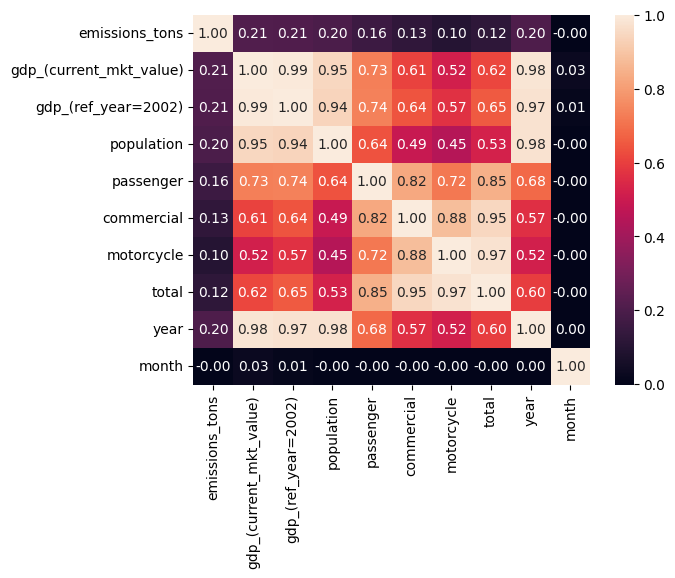

In [ ]:
columns = ['emissions_tons','gdp_(current_mkt_value)', 'gdp_(ref_year=2002)', 'population',
       'passenger', 'commercial', 'motorcycle', 'total', 'year', 'month']
CO_numeric = co_train[columns]
sns.heatmap(CO_numeric.corr(),
            annot=True,
            fmt=".2f")

1. `emission_tons` has slightly positive correlation against the independent variables. (corr~ 0.12-0.21).
2. independent variables has strong positive correlation against each other (corr~ 0.52-1.00). This may pose a problem of `Autocorrelation`.


**III. Statistical Significance**

In [ ]:
# Ordinary Least Square Method
def OLS(target_variable, data):
  Y = data[target_variable]
  X = data.drop([target_variable], axis=1)
  X = sm.add_constant(X)
  model = sm.OLS(Y, X)
  results = model.fit()
  return results

In [ ]:
results = OLS("emissions_tons", CO_numeric)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         emissions_tons   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.79
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.58e-16
Time:                        02:54:05   Log-Likelihood:                -17349.
No. Observations:                1992   AIC:                         3.472e+04
Df Residuals:                    1983   BIC:                         3.477e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

1. The model has very weak explanatory power, with `r-squared` of 0.045 and `adj r-squared` of 0.042 only.
2. ALL variables are not statistically siginificant.

**IV. Mutual Information Score**

In [ ]:
co_train_da = co_train.copy()
co_train_da["year_"] = co_train_da["year"].astype(str)

In [ ]:
emission_grp_year = co_train_da.groupby(["year", "month"]).sum()["emissions_tons"].reset_index()

Text(0, 0.5, 'CO2 Emissions (tons)')

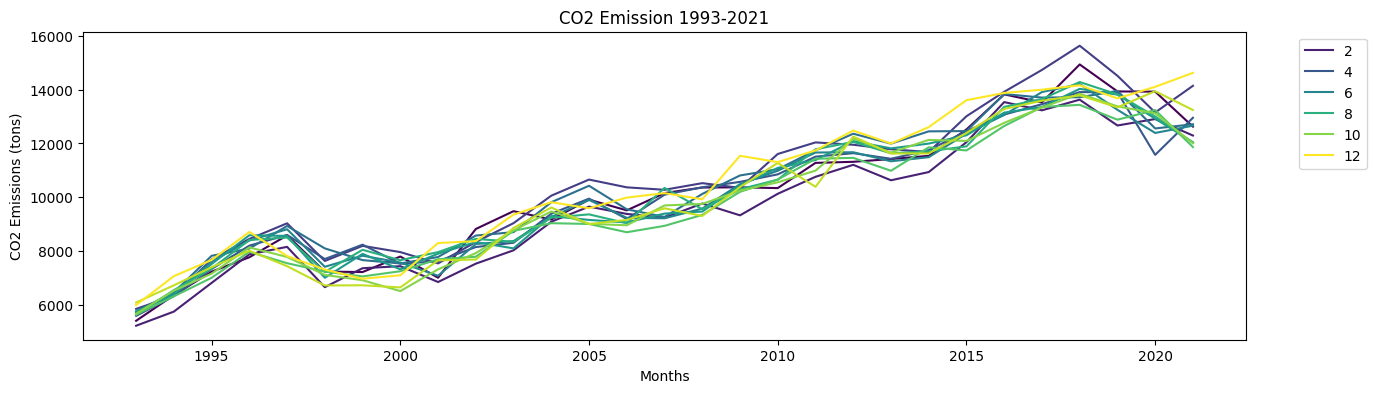

In [ ]:
plt.figure(figsize=(15, 4))
sns.lineplot(emission_grp_year,
             x="year",
             y="emissions_tons",
             hue="month",
             palette="viridis")

plt.title("CO2 Emission 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")